## The microbial consumer-resource model (MiCRM)

\begin{align}
    \frac{dC_i}{dt} &= C_i \left( \sum_a u_{ia}(T) (1-\sum_b l^i_{a b}) R_a - m_i(T)\right) \label{eq:Consumer_Chap2},
    \\
    \frac{dR_a}{dt} &= \rho_a (R) - \sum_{i=1}^{N}\Bigl(C_iu_{ia}(T)R_a-\sum_{b =1}^{M}C_iu_{ib}(T)R_b l^i_{b a}\Bigl) \label{eq:Resource_Chap2}.
\end{align}

Symbols | Definition | Initial values | Units |
|---|---|---|---|
| $M$ | Number of resource types | $50$ | individual |
| $N$ | Number of consumer species | $100$ | individual |
| $C_i$ | Biomass concentration of consumer $i$ | $0.1$ | mass |
| $R_a$ | Resource concentration of resource $a$ | $1.0$ | mass |
| $u_{ia}$ |  Uptake rate of consumer $i$ on resource $a$ | Temperature-dependent | 1/mass*time |
| $m_i$ | Maintenance cost of consumer $i$ | Temperature-dependent | 1/time |
| $l^i_{ab}$ | Leakage/transformation fraction of resource $a$ to $b$ by species $i$ | $l^i_\alpha = 0.3$ | fraction |
| $\rho_a$ | External resource supply of resource $a$ | $1.0$ | mass/time |

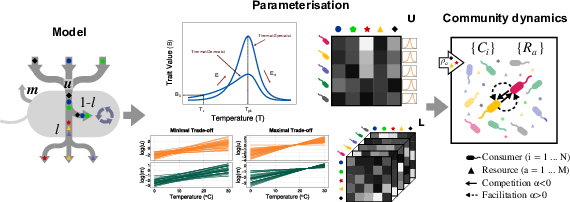

In [1]:
using Images; 
load("../results/MiCRM.pdf")

In [1]:
### open to display in a different window for clearer view
run(`open ../results/MiCRM.pdf`); 

## TPC

\begin{equation}
    B(T) = \frac{B_0\times {e^{\frac{-E}{k}\cdot\left(\frac{1}{T} - \frac{1}{T_r}\right)}}}{1 + \frac{E}{E_d-E}e^{\frac{E_d}{k}\cdot(\frac{1}{T_{pk}}-\frac{1}{T})}}
\end{equation}

Symbols | Definition | Initial values | Units |
|---|---|---|---|
| $B_{0,u}$ | Normalization constant for uptake rate | $0.22$ | 1/mass*time |
| $B_{0,m}$ | Normalization constant for maintenance respiration rate | $0.44$ | 1/time |
| $E_u$ | Activation energy for uptake rate | $0.81$ | eV |
| $E_m$ | Activation energy for maintenance respiration rate | $0.57$ | eV |
| $k$ | Boltzmann constant | $8.62 * 10^{-5}$ | eV/K |
| $T$ | Model temperature | $273.15 \sim 303.15$ | K |
| $T_{r}$ | Reference temperature | $283.15$ | K |
| $E_{d,u}$ | Deactivation energy for uptake rate | $3.5$ | eV |
| $E_{d, m}$ | Deactivation energy for maintenance respiration rate | $3.5$ | eV |
| $T_{pk,u}$ | Peak temperature for uptake rate | $308.15$ | K |
| $T_{pk,m}$ | Peak temperature for maintenance respiration rate | $311.15$ | K |


## Model settings

In [1]:
include("./sim_frame.jl");

In [2]:
### Model params
N=7;
M=5;
L = fill(0.3, N);
tspan = (0.0, 2.5e10); 
x0 = vcat(fill(0.1, N), fill(1, M)); # initial biomass and resource abundance

In [3]:
### Temp params 
num_temps = 31; # Running for 31 temp steps from 0 to 30 ᵒC 
# ρ_t= [-0.3500 -0.3500]; # Realistic trade-off
ρ_t= [0.0000 0.0000]; # Minimal trade-off
# ρ_t= [-0.9999 -0.9999]; # Maximal trade-off
Tr=273.15+10; # reference temperature
Ed=3.5; # high temp deactivation

In [4]:
### Defining Callback
condition(du, t, integrator) = norm(integrator(t, Val{1})) <= eps(); # terminates integration as soon as SYSTEM reaches steady state
affect!(integrator) = terminate!(integrator);
cb = DiscreteCallback(condition, affect!);

## Example simulation at 15 ᵒC 

In [5]:
### generating model params
T = 273.15 + 15;
Random.seed!(111)
p = generate_params(N, M; f_u=F_u, f_m=F_m, f_ρ=F_ρ, f_ω=F_ω, L=L, T=T, ρ_t=ρ_t, Tr=Tr, Ed=Ed);

In [6]:
### uptake matrix
p.u

7×5 Matrix{Float64}:
 0.0262173  0.0695724   0.332753   0.0069291   0.0339546
 0.70507    0.112296    0.0852264  0.00935596  0.054404
 0.244083   0.0445267   0.293244   0.297702    0.0408204
 0.392227   0.00322254  0.0932952  0.278615    0.473632
 0.35967    0.888619    0.158371   0.0260687   0.0132991
 0.161427   0.0412588   0.0279699  0.143839    0.0886614
 0.125232   0.0863596   0.294592   0.111326    0.157316

In [7]:
### respiration rates
p.m

7-element Vector{Float64}:
 0.3852516919174677
 0.2161397319121929
 0.1559496890219075
 0.8196864253207721
 0.46498535494985205
 0.1724245832297488
 0.12971480259439244

In [8]:
### N*M*M leakage-transformation tensor
p.l

7×5×5 Array{Float64, 3}:
[:, :, 1] =
 0.000331086  0.0279491   0.0197256  0.0819987  0.0143627
 0.0180347    0.0862644   0.0823347  0.0234113  0.127224
 0.0442873    0.0641999   0.032844   0.0425057  0.0557552
 0.0497738    0.133023    0.0823212  0.0257396  0.0380462
 0.128369     0.00767637  0.0055803  0.0823412  0.000329248
 0.0977905    0.0590187   0.100187   0.0968024  0.138017
 0.0325845    0.0022801   0.0762495  0.063565   0.00818391

[:, :, 2] =
 0.0211951  0.0646989  0.0126192   0.0306171   0.0341802
 0.0180693  0.045422   0.053219    0.0783442   0.0728116
 0.143793   0.0732112  0.0341534   0.0311049   0.111065
 0.0470311  0.0391663  0.00173902  0.153492    0.0215793
 0.0486061  0.128805   0.13389     0.0572806   0.0551693
 0.156165   0.0610409  0.0637581   0.00214149  0.00367934
 0.0539961  0.0768865  0.117196    0.037076    0.0320946

[:, :, 3] =
 0.0535922  0.157682    0.022688   0.141084   0.0291245
 0.244613   0.0275092   0.0157872  0.0229281  0.0148515
 0.0720295  0.00118

In [9]:
## solving
prob = ODEProblem(dxx!, x0, tspan, p);
sol =solve(prob, AutoVern7(Rodas5()), save_everystep = true, callback=cb);
bm_dyn = hcat(sol.u[1: length(sol.t)]...)[1:N, :]; # collecting biomass abundance
R_t_dyn = hcat(sol.u[1: length(sol.t)]...)[N+1:N+M, :]; # collecting resource abundance

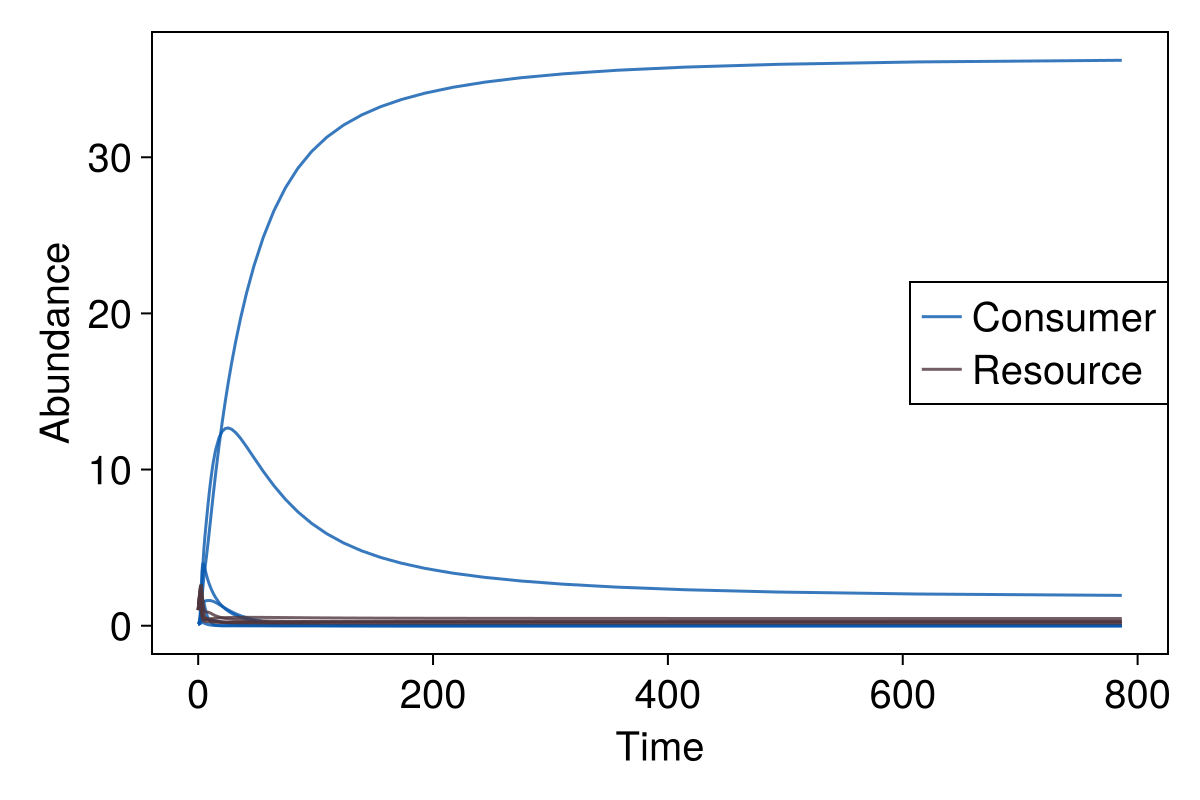

In [10]:
f = Figure(fontsize = 20, size = (600, 400));
ax1 = Axis(f[1,1], xlabel = "Time", ylabel = "Abundance", ygridvisible = false, xgridvisible = false)
for i in 1:N 
    lines!(ax1, sol.t[1:50], bm_dyn[i,1:50], color = ("#0758AE",0.8), linewidth = 1.5)
end
for i in 1:M
    lines!(ax1, sol.t[1:50], R_t_dyn[i,1:50], color = ("#4F363E",0.8), linewidth = 1.5)
end
l1 = [LineElement(color = ("#0758AE",0.8), linestyle = nothing, linewidth = 1.5)]
l2 = [LineElement(color = ("#4F363E", 0.8), linestyle = nothing, linewidth = 1.5)]
Legend(f[1,1], [l1, l2], tellheight = false, tellwidth = false, ["Consumer", "Resource"], halign = :right, valign = :center)
f


In [11]:
## equilibrium biomass
bm = sol.u[length(sol.t)][1:N]

7-element Vector{Float64}:
 -1.1200663585460695e-55
 -2.2533819373344928e-27
  1.8766663117100237
 -5.507452328922047e-59
 -2.180366680034006e-30
 -2.541437704725556e-35
 36.289878858393536

In [12]:
## equilibium resource abundance
R_t = sol.u[length(sol.t)][N+1:N+M]

5-element Vector{Float64}:
 0.2538121376117814
 0.46048071739978513
 0.15465265703547354
 0.2874991726148277
 0.2300401535748076

In [13]:
## ID of survivors
sur = (1:N)[bm .> 1.0e-7] # threshold e-7 

2-element Vector{Int64}:
 3
 7

In [14]:
## Equilibrium community richness
N_s = length(sur)

2

In [15]:
## Species-level CUE
ϵ = (p.u * x0[N+1:N+M] .* (1 .- p.L) .- p.m) ./ (p.u * x0[N+1:N+M])

7-element Vector{Float64}:
 -0.12068570621338891
  0.4763345206103351
  0.5305587318586464
  0.03949110106765063
  0.37843955482506264
  0.3277177811644016
  0.5325884105237659

## Effective LV

\begin{equation}
    \frac{dC_i}{dt} \approx C_i(r_i(T)+\sum_j \alpha_{ij}(T)C_j)
\end{equation}
where
\begin{align}
    & \alpha_{ij} = \sum_a u_{ia}(1 - l^i_a)\frac{\partial \hat{R_a}}{\partial C_j}\\
    & r_i = \sum_a u_{ia}(1-l^i_a)\hat{R_a} -\sum_j \alpha_{ij} \hat{C_j} - m_i
\end{align}

In [16]:
### !!! new callback condition
condition_lv(du, t, integrator) = norm(integrator(t, Val{1})[N:N+M]) <= eps(); # terminates integration as soon as RESOURCE ABUNDANCE reaches steady state
cb_lv = DiscreteCallback(condition_lv, affect!);
## solving
prob_lv = ODEProblem(dxx!, x0, tspan, p);
sol_lv =solve(prob, AutoVern7(Rodas5()), save_everystep = true, callback=cb_lv);

In [17]:
### getting effective LV coefficients
p_lv = Eff_LV_params(p=p, sol=sol);

In [18]:
### Interaction matrix A
p_lv.ℵ

7×7 Matrix{Float64}:
 -0.00133569   -0.00194635  -0.00138926  …  -0.000737045  -0.00154316
 -0.00221604   -0.0165502   -0.00608627     -0.00377156   -0.00460379
 -0.00172992   -0.00701494  -0.00622945     -0.00330118   -0.00369467
 -0.00197299   -0.0102674   -0.00722355     -0.00446404   -0.00542001
 -0.00757908   -0.0179701   -0.00850858     -0.00590219   -0.0103636
 -0.000930975  -0.00450713  -0.00334596  …  -0.00195841   -0.00226329
 -0.00186553   -0.0047181   -0.00360543     -0.00211543   -0.00313883

In [19]:
### Maximal growth rate r
p_lv.r

7-element Vector{Float64}:
 -0.2566746625368772
  0.14368879070340704
  0.14576972392053986
 -0.39627449480124355
  0.3019452668431838
  0.004221349788446238
  0.12067380303433489

In [20]:
### Jacobian matrix
LV_jac = Eff_Lv_Jac(p_lv=p_lv, sol=sol)

2×2 Matrix{Float64}:
 -0.0116906  -0.00693366
 -0.130841   -0.113908

In [21]:
### leading eigen value
jac_eigen = eigen(LV_jac).values;
leading = jac_eigen[argmax(real.(jac_eigen))]

-0.0034755572737723145